# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

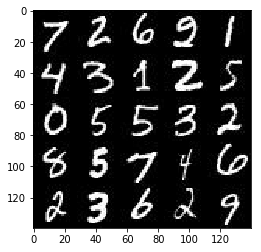

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

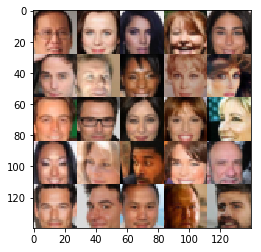

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        # Input layer is 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 56
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 112

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*112))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train) as scope:
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*112)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 112))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 112 now
        
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 56 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x out_channel_dim now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [69]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Network Initialization
    tf.reset_default_graph()
    
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # training interation initialization
    steps = 0
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    n_images = 12
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
    print('training done')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9649... Generator Loss: 0.6632
Epoch 1/2... Discriminator Loss: 0.5818... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 0.7361... Generator Loss: 1.1447
Epoch 1/2... Discriminator Loss: 0.8281... Generator Loss: 1.2471
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.0199
Epoch 1/2... Discriminator Loss: 0.6101... Generator Loss: 2.0235
Epoch 1/2... Discriminator Loss: 0.6195... Generator Loss: 1.1854
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 0.7485... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.4281


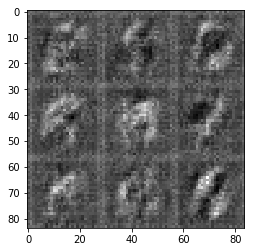

Epoch 1/2... Discriminator Loss: 0.7410... Generator Loss: 1.3858
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.0422
Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 1.7546
Epoch 1/2... Discriminator Loss: 0.7170... Generator Loss: 1.0449
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 0.8745
Epoch 1/2... Discriminator Loss: 0.6462... Generator Loss: 1.1315
Epoch 1/2... Discriminator Loss: 0.5820... Generator Loss: 1.3140
Epoch 1/2... Discriminator Loss: 0.7655... Generator Loss: 1.9705
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 1.7634
Epoch 1/2... Discriminator Loss: 0.5534... Generator Loss: 2.1757


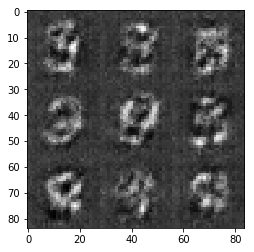

Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 0.9487
Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 1.7484
Epoch 1/2... Discriminator Loss: 0.6281... Generator Loss: 1.4274
Epoch 1/2... Discriminator Loss: 0.5613... Generator Loss: 1.4423
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 1.1422
Epoch 1/2... Discriminator Loss: 0.5207... Generator Loss: 1.5910
Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 1.5044
Epoch 1/2... Discriminator Loss: 0.4929... Generator Loss: 2.1054
Epoch 1/2... Discriminator Loss: 0.5555... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 2.6349


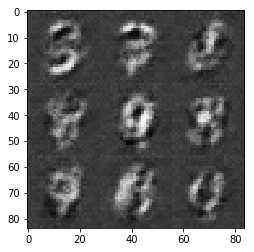

Epoch 1/2... Discriminator Loss: 0.3908... Generator Loss: 1.8353
Epoch 1/2... Discriminator Loss: 0.4591... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 0.5108... Generator Loss: 1.1873
Epoch 1/2... Discriminator Loss: 0.6803... Generator Loss: 2.9501
Epoch 1/2... Discriminator Loss: 0.6717... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 0.5935... Generator Loss: 2.9120
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 1.7311
Epoch 1/2... Discriminator Loss: 0.4069... Generator Loss: 1.5391
Epoch 1/2... Discriminator Loss: 0.4112... Generator Loss: 2.3486
Epoch 1/2... Discriminator Loss: 0.4482... Generator Loss: 2.6924


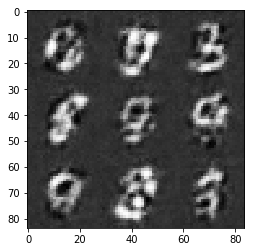

Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 1.3375
Epoch 1/2... Discriminator Loss: 0.4279... Generator Loss: 2.6567
Epoch 1/2... Discriminator Loss: 0.4499... Generator Loss: 1.2764
Epoch 1/2... Discriminator Loss: 0.3873... Generator Loss: 1.7366
Epoch 1/2... Discriminator Loss: 0.3630... Generator Loss: 2.2338
Epoch 1/2... Discriminator Loss: 0.3262... Generator Loss: 1.8918
Epoch 2/2... Discriminator Loss: 0.4117... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 0.3015... Generator Loss: 1.9484
Epoch 2/2... Discriminator Loss: 0.3182... Generator Loss: 1.8999
Epoch 2/2... Discriminator Loss: 0.3066... Generator Loss: 2.6687


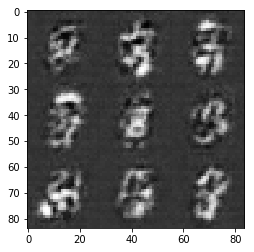

Epoch 2/2... Discriminator Loss: 0.2646... Generator Loss: 2.0324
Epoch 2/2... Discriminator Loss: 0.2677... Generator Loss: 2.4796
Epoch 2/2... Discriminator Loss: 0.2511... Generator Loss: 2.4627
Epoch 2/2... Discriminator Loss: 0.3160... Generator Loss: 2.5721
Epoch 2/2... Discriminator Loss: 0.3009... Generator Loss: 2.4401
Epoch 2/2... Discriminator Loss: 0.3173... Generator Loss: 1.7488
Epoch 2/2... Discriminator Loss: 0.3261... Generator Loss: 1.6562
Epoch 2/2... Discriminator Loss: 0.2724... Generator Loss: 2.0271
Epoch 2/2... Discriminator Loss: 0.3037... Generator Loss: 1.7615
Epoch 2/2... Discriminator Loss: 0.3325... Generator Loss: 2.8923


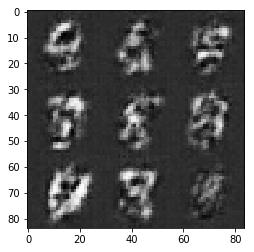

Epoch 2/2... Discriminator Loss: 0.2430... Generator Loss: 2.7599
Epoch 2/2... Discriminator Loss: 0.2488... Generator Loss: 2.0370
Epoch 2/2... Discriminator Loss: 0.2301... Generator Loss: 2.7333
Epoch 2/2... Discriminator Loss: 0.2514... Generator Loss: 2.1010
Epoch 2/2... Discriminator Loss: 0.2426... Generator Loss: 2.2435
Epoch 2/2... Discriminator Loss: 0.2452... Generator Loss: 2.7202
Epoch 2/2... Discriminator Loss: 0.4112... Generator Loss: 1.3458
Epoch 2/2... Discriminator Loss: 0.3489... Generator Loss: 1.5422
Epoch 2/2... Discriminator Loss: 0.2191... Generator Loss: 2.6059
Epoch 2/2... Discriminator Loss: 0.2206... Generator Loss: 2.5773


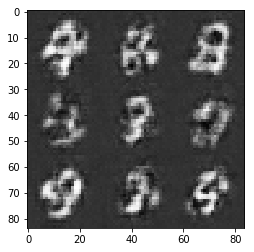

Epoch 2/2... Discriminator Loss: 0.3151... Generator Loss: 1.5765
Epoch 2/2... Discriminator Loss: 0.3366... Generator Loss: 1.6436
Epoch 2/2... Discriminator Loss: 0.2226... Generator Loss: 2.2065
Epoch 2/2... Discriminator Loss: 0.2192... Generator Loss: 2.2670
Epoch 2/2... Discriminator Loss: 0.2358... Generator Loss: 2.2277
Epoch 2/2... Discriminator Loss: 0.1745... Generator Loss: 2.7996
Epoch 2/2... Discriminator Loss: 0.2147... Generator Loss: 2.4924
Epoch 2/2... Discriminator Loss: 0.2010... Generator Loss: 3.1729
Epoch 2/2... Discriminator Loss: 0.1838... Generator Loss: 2.8947
Epoch 2/2... Discriminator Loss: 0.2119... Generator Loss: 2.5414


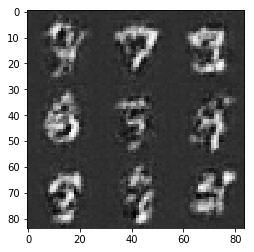

Epoch 2/2... Discriminator Loss: 0.2197... Generator Loss: 2.3437
Epoch 2/2... Discriminator Loss: 0.2165... Generator Loss: 2.1713
Epoch 2/2... Discriminator Loss: 0.1702... Generator Loss: 2.5711
Epoch 2/2... Discriminator Loss: 0.1480... Generator Loss: 2.6383
Epoch 2/2... Discriminator Loss: 0.1571... Generator Loss: 3.1591
Epoch 2/2... Discriminator Loss: 0.1681... Generator Loss: 3.3474
Epoch 2/2... Discriminator Loss: 0.1612... Generator Loss: 2.6116
Epoch 2/2... Discriminator Loss: 0.2232... Generator Loss: 3.4638
Epoch 2/2... Discriminator Loss: 0.1617... Generator Loss: 2.6796
Epoch 2/2... Discriminator Loss: 0.1533... Generator Loss: 2.8515


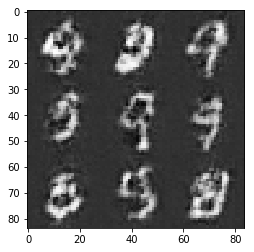

Epoch 2/2... Discriminator Loss: 0.1353... Generator Loss: 3.3023
Epoch 2/2... Discriminator Loss: 0.1535... Generator Loss: 2.7498
Epoch 2/2... Discriminator Loss: 0.1475... Generator Loss: 3.0016
training done


IndexError: list index out of range

In [70]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.5251
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 1.6033
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 1.8095
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 2.0338
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 1.8405
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 1.5449


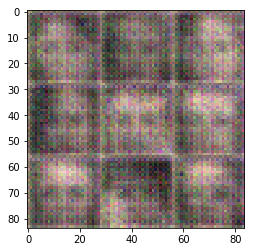

Epoch 1/1... Discriminator Loss: 0.2971... Generator Loss: 1.9939
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 1.6363
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 0.8996


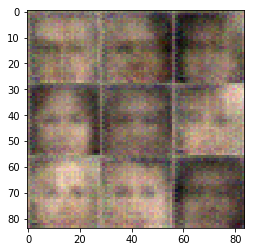

Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 2.2823
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.9380
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.4485
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.0970


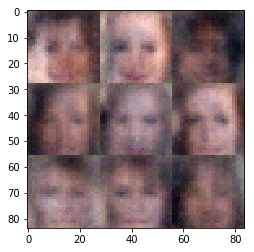

Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7123


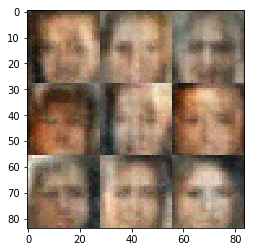

Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.4005
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7161


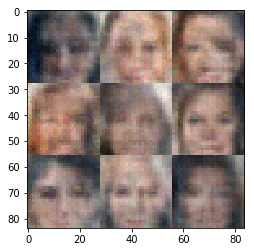

Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.2888


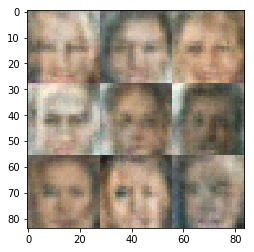

Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.2926


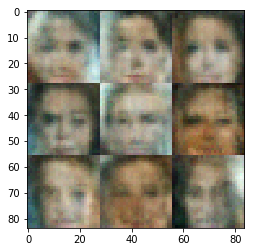

Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 2.5066
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.9343
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 3.1546


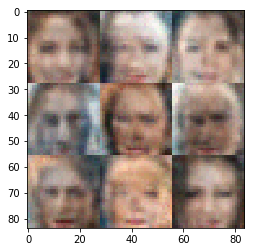

Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 2.1741
Epoch 1/1... Discriminator Loss: 1.8917... Generator Loss: 0.2164
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 2.3771
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.3155
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 1.7151
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.6994
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.4991


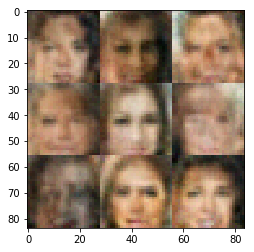

Epoch 1/1... Discriminator Loss: 0.4508... Generator Loss: 1.8807
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 2.1067
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.3436
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.5548
Epoch 1/1... Discriminator Loss: 2.4411... Generator Loss: 0.1150
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.9165


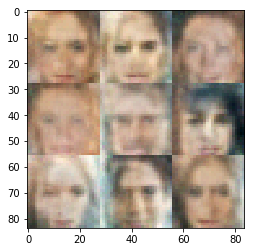

Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 1.9123
Epoch 1/1... Discriminator Loss: 2.2602... Generator Loss: 0.1337
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.3775


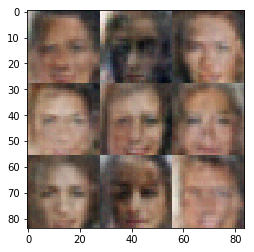

Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 2.1754
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.7437
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 2.3066
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.0583


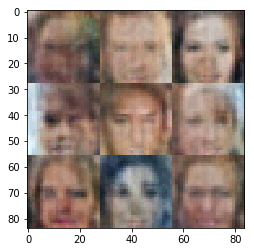

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.8566
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.7692... Generator Loss: 0.2342
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 2.1285


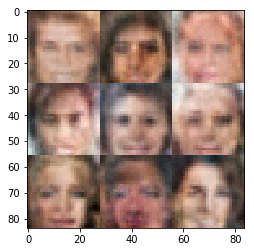

Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.6097
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.2490
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 2.0700
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 2.8123
Epoch 1/1... Discriminator Loss: 0.5212... Generator Loss: 1.6081
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.5572
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 4.4789
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.1944


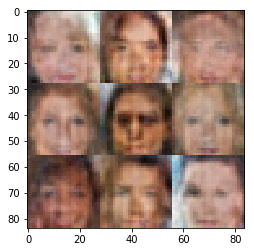

Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.2632
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.7348
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 3.3764
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.7945


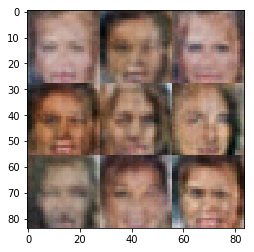

Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 2.6370
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.2323
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 3.1207
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 3.5787
training done


IndexError: list index out of range

In [66]:
batch_size = 128
z_dim = 20
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.